# $\chi^2$ debugger #

1. `get_data` revised, `cov` outputs zeroed off-diag elements


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from scipy.linalg import kron
import scipy as sp

In [2]:
plt.rcdefaults()
plt.rcParams.update({'figure.dpi':100})
plt.rcParams.update({'figure.autolayout':'True'})
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.family': 'sans-serif'})
plt.rcParams.update({'mathtext.default':'regular'})
plt.rcParams.update({'mathtext.fontset':'stixsans'})
plt.rcParams.update({'axes.linewidth': 1.5})
plt.rcParams.update({'xtick.major.width': 1.25 })
plt.rcParams.update({'xtick.minor.size': 2.5})
plt.rcParams.update({'xtick.minor.width': 1.25 })
plt.rcParams.update({'ytick.major.size': 5})
plt.rcParams.update({'ytick.major.width': 1.25 })
plt.rcParams.update({'ytick.minor.size': 2.5})
plt.rcParams.update({'ytick.minor.width': 1.25 })
plt.rc('legend',**{'fontsize':'x-small'})
#plt.figure(1,figsize = [11.0, 8.5])
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams.update({'xtick.top':'True'})
plt.rcParams.update({'ytick.right':'True'})
plt.rcParams.update({'axes.formatter.limits': (-2, 2)})
# My own adds to Carles' rcParams updates
#plt.rcParams.update({'lines.markersize': 8}) 6 is the default
plt.rcParams.update({'legend.framealpha': 1.0})
plt.rcParams.update({'legend.fancybox': 'False'})

In [3]:
pz_ranges = np.array([0, 0.3, 0.6, 0.9, 1.2, 1.5, np.inf])
im_ranges = np.array([17, 18, 19, 20, 21, 22, 23, np.inf])
colorwheel = ['blue', 'red', 'green', 'orange', 'teal', 'purple', 'cyan', 'pink', 'olive']

In [4]:
ng_col_names = ['r_nom', 'meanr', 'meanlogr', 'gamT', 'gamX', 'sigma', 'weight', 'npairs']
ng_col_formats = ['f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8']

nn_col_names = ['r_nom', 'meanr', 'meanlogr', 'xi', 'sigma_xi', 'DD', 'RR', 'DR', 'npairs']
nn_col_formats = ['f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8']

In [5]:
def data_path_builder(corr, data, pz_range):
    '''
    Obtain a list of paths of a specific type for a given pz_range
    corr: 'NG', 'NN'
    data: 'main', 'cor', 'cov'
    '''
    paths = []
    for i in range(len(pz_range)):
        #if (pz_range[i]<np.max(pz_range)):
        if (data=='main'):
            path = 'Result/{}_data/{:.1f}<zl<{:.1f}'.format(corr, pz_range[i], pz_range[i]+0.3)
            paths.append(path)
        else:
            path = 'Result/{}_data/{}_{:.1f}<zl<{:.1f}'.format(corr, data, pz_range[i], pz_range[i]+0.3)
            paths.append(path)
    return paths

def theo_path_builder(corr, prpt, pz_range):
    '''
    Obtain a list of paths of a specific type for a given pz_range
    corr: 'NG', 'NN'
    prpt: 'theta', 'xi'
    '''
    paths = []
    for i in range(len(pz_range)):
        path = "Result/{}_model/{}_{:.1f}<zl<{:.1f}".format(corr, prpt, pz_range[i], pz_range[i]+0.3)
        paths.append(path)
    return paths

data_ng_paths = data_path_builder('NG', 'main', pz_ranges[1:-3])
data_nn_paths = data_path_builder('NN', 'main', pz_ranges[1:-2])

data_ng_cov_paths = data_path_builder('NG', 'cov', pz_ranges[1:-3])
data_nn_cov_paths = data_path_builder('NN', 'cov', pz_ranges[1:-2])

theo_ng_theta_paths = theo_path_builder('NG', 'theta', pz_ranges[1:-3])
theo_nn_theta_paths = theo_path_builder('NN', 'theta', pz_ranges[1:-2])

theo_ng_xi_paths = theo_path_builder('NG', 'xi', pz_ranges[1:-3])
theo_nn_xi_paths = theo_path_builder('NN', 'xi', pz_ranges[1:-2])

In [6]:
def cov_diag(cov):
    '''
    cov: full covariance matrix
    output: cov with all elements but diagonal being zero
    '''
    diag = np.diag(cov)
    shape = cov.shape
    cov_new = np.zeros(shape)
    np.fill_diagonal(cov_new, diag)
    return cov_new

In [7]:
######## get_data revised, cov outputs zeroed off-diag elements #########
def get_data(corr, i):
    '''
    corr = 'NG', 'NN'
    i: index
    '''
    if (corr == 'NG'):
        data = np.loadtxt(data_ng_paths[i], 
                          dtype={'names': ng_col_names,
                                 'formats': ng_col_formats})
        r = np.exp(data['meanlogr'])
        xi = data['gamT']*(-1)
        sig = data['sigma']
        cov = cov_diag(np.loadtxt(data_ng_cov_paths[i]))
        
    if (corr == 'NN'):
        data = np.loadtxt(data_nn_paths[i], 
                          dtype={'names': nn_col_names,
                                 'formats': nn_col_formats})
        r = np.exp(data['meanlogr'])
        xi = data['xi']
        sig = data['sigma_xi']
        cov = cov_diag(np.loadtxt(data_nn_cov_paths[i]))
    return r, xi, sig, cov

In [8]:
def get_theo(corr, i):
    '''
    corr = 'NG', 'NN'
    i: index
    '''
    if (corr == 'NG'):
        theta_arcmin = np.loadtxt(theo_ng_theta_paths[i])*60
        xi = np.loadtxt(theo_ng_xi_paths[i])
    if (corr == 'NN'):
        theta_arcmin = np.loadtxt(theo_nn_theta_paths[i])*60
        xi = np.loadtxt(theo_nn_xi_paths[i])
    return theta_arcmin, xi

In [9]:
def get_chi_sq(data, model, cov):
    #Feed interpolated model
    return (data-model).T@sp.linalg.inv(cov)@(data-model)

In [10]:
def plot_chi_sq(ax, b, chi_sqs, label, color):
    ax.plot(b, chi_sqs, label=label, color=color)
    ax.set_xlabel(r'b')
    ax.set_ylabel(r'$\chi^2(b)$')
    ax.set_yscale('log')
    return

In [11]:
def get_chi_sq_ng(pz_range):
    b = np.linspace(0, 4, 500)
    fig, ax = plt.subplots(1, 1)
    min_b = np.ones(len(pz_range))
    min_chi = np.ones(len(pz_range))
    for i in range(len(pz_range)):
        label = '{:.1f}<z_l<{:.1f}'.format(pz_range[i], pz_range[i]+0.3)
        r_data, xi_data, xi_sig, cov = get_data('NG', i)
        r_theo, xi_theo = get_theo('NG', i)
        f = interpolate.interp1d(r_theo, xi_theo)
        xi_theo_interp = f(r_data)
        xi_model_mat = b[:,None]@xi_theo_interp[:,None].T
        chi_sqs = np.ones(len(b))
        for j in range(len(b)):
            xi_model = xi_model_mat[j]
            chi_sq = get_chi_sq(xi_data, xi_model, cov)
            chi_sqs[j] = chi_sq
        plot_chi_sq(ax, b, chi_sqs, label, colorwheel[i])
        min_chi[i] = np.min(chi_sqs)
        min_b[i] = b[chi_sqs == np.min(chi_sqs)]
    ax.legend()
    ax.set_title(r'$\chi^2$ fitting for NG Correlation Function')
    return min_b, min_chi

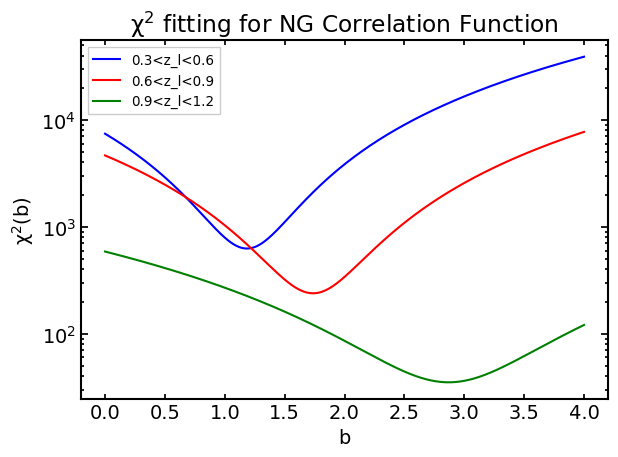

In [12]:
ng_min_b, ng_min_chi = get_chi_sq_ng(pz_ranges[1:-3])

(array([1.18637275, 1.73947896, 2.86973948]),
 array([626.18731099, 238.71908091,  35.07527449]))

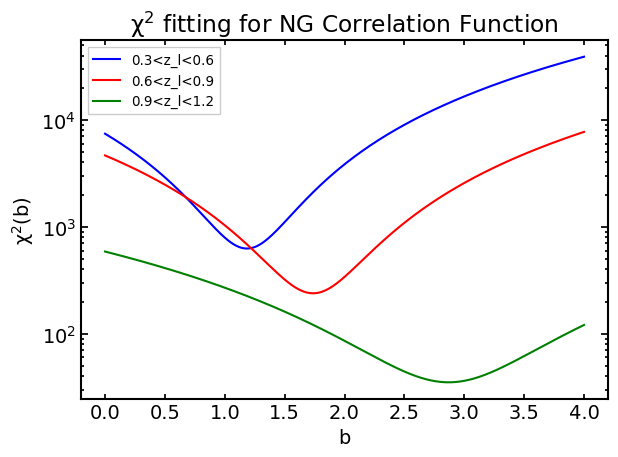

In [13]:
get_chi_sq_ng(pz_ranges[1:-3])

In [14]:
def get_chi_sq_nn(pz_range):
    b = np.linspace(0, 4, 500)
    fig, ax = plt.subplots(1, 1)
    min_b = np.ones(len(pz_range))
    min_chi = np.ones(len(pz_range))
    for i in range(len(pz_range)):
        label = '{:.1f}<pz<{:.1f}'.format(pz_range[i], pz_range[i]+0.3)
        r_data, xi_data, xi_sig, cov = get_data('NN', i)
        r_theo, xi_theo = get_theo('NN', i)
        f = interpolate.interp1d(r_theo, xi_theo)
        xi_theo_interp = f(r_data)
        xi_model_mat = (b**2)[:,None]@xi_theo_interp[:,None].T
        chi_sqs = np.ones(len(b))
        for j in range(len(b)):
            xi_model = xi_model_mat[j]
            chi_sq = get_chi_sq(xi_data, xi_model, cov)
            chi_sqs[j] = chi_sq
        plot_chi_sq(ax, b, chi_sqs, label, colorwheel[i])
        min_chi[i] = np.min(chi_sqs)
        min_b[i] = b[chi_sqs == np.min(chi_sqs)]
    ax.legend()
    ax.set_title(r'$\chi^2$ fitting for NN Correlation Function')
    return min_b, min_chi

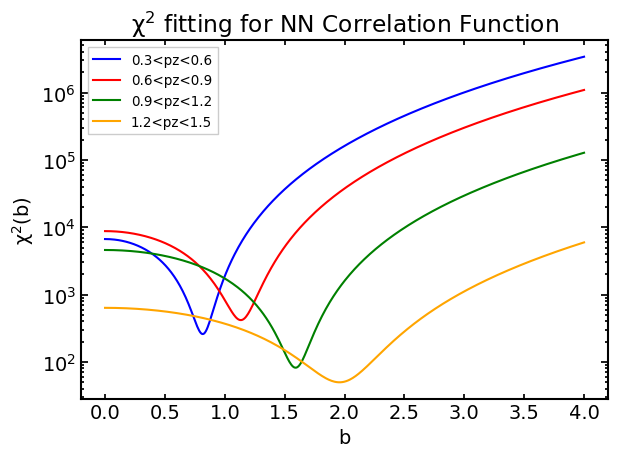

In [15]:
nn_min_b, nn_min_chi = get_chi_sq_nn(pz_ranges[1:-2])

(array([0.81763527, 1.13026052, 1.59519038, 1.95591182]),
 array([259.14993043, 418.01031084,  82.12040344,  49.78308084]))

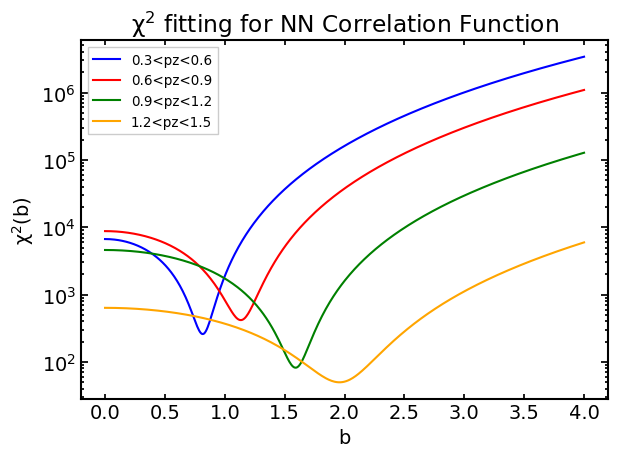

In [16]:
get_chi_sq_nn(pz_ranges[1:-2])

In [17]:
def plot_xi(fig_type, ax, r, xi, label, color, sig=0):
    if (fig_type == 'scatter'):
        ax.scatter(r, xi, label=label, color=color)
    elif (fig_type == 'plot'):
        ax.plot(r, xi, label=label, color=color)
    ax.set_xlabel(r'$\theta$[arcmin]')
    ax.set_ylabel(r'$\xi(\theta)$')
    ax.set_xscale('log')
    ax.set_yscale('log', nonposy='clip')
    if (type(sig)!=int):
        ax.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], 
                    color='blue', lw=0.7, ls='')
    return

In [18]:
def plot_xi_mod(fig_type, ax, r, xi, label, color, sig=0):
    if (fig_type == 'scatter'):
        ax.scatter(r, r*xi, label=label, color=color)
    elif (fig_type == 'plot'):
        ax.plot(r, r*xi, label=label, color=color)
    ax.set_xlabel(r'$\theta$[arcmin]')
    ax.set_ylabel(r'$\theta\times\xi$')
    ax.set_xscale('log')
    if (type(sig)!=int):
        ax.errorbar(r, r*xi, yerr=r*sig, 
                    color='blue', lw=0.7, ls='')
    return

In [19]:
def min_b_ng_comp(pz_range, min_b):
    fig, ax = plt.subplots(len(pz_range), 2, figsize=(10, 15))
    for i in range(len(pz_range)):
        b = min_b[i]
        title = '{:.1f}<z_l<{:.1f}, b={:.2f}'.format(pz_range[i], pz_range[i]+0.3, b)
        ax[i][0].set_title(title)
        ax[i][1].set_title(title)
        r_data, xi_data, xi_sig, cov = get_data('NG', i)
        r_theo, xi_theo = get_theo('NG', i)
        f = interpolate.interp1d(r_theo, xi_theo)
        xi_theo_interp = f(r_data)
        xi_model = b*xi_theo_interp
        
        plot_xi_mod('scatter', ax[i][0], r_data, xi_data, 'Data', 'blue', xi_sig)
        plot_xi_mod('plot', ax[i][0], r_theo, xi_theo, 'Theory', 'red')
        plot_xi_mod('plot', ax[i][0], r_data, xi_model, 'Model', 'green')
        
        plot_xi('scatter', ax[i][1], r_data, xi_data, 'Data', 'blue', xi_sig)
        plot_xi('plot', ax[i][1], r_theo, xi_theo, 'Theory', 'red')
        plot_xi('plot', ax[i][1], r_data, xi_model, 'Model', 'green')
        ax[i][1].legend()
    return

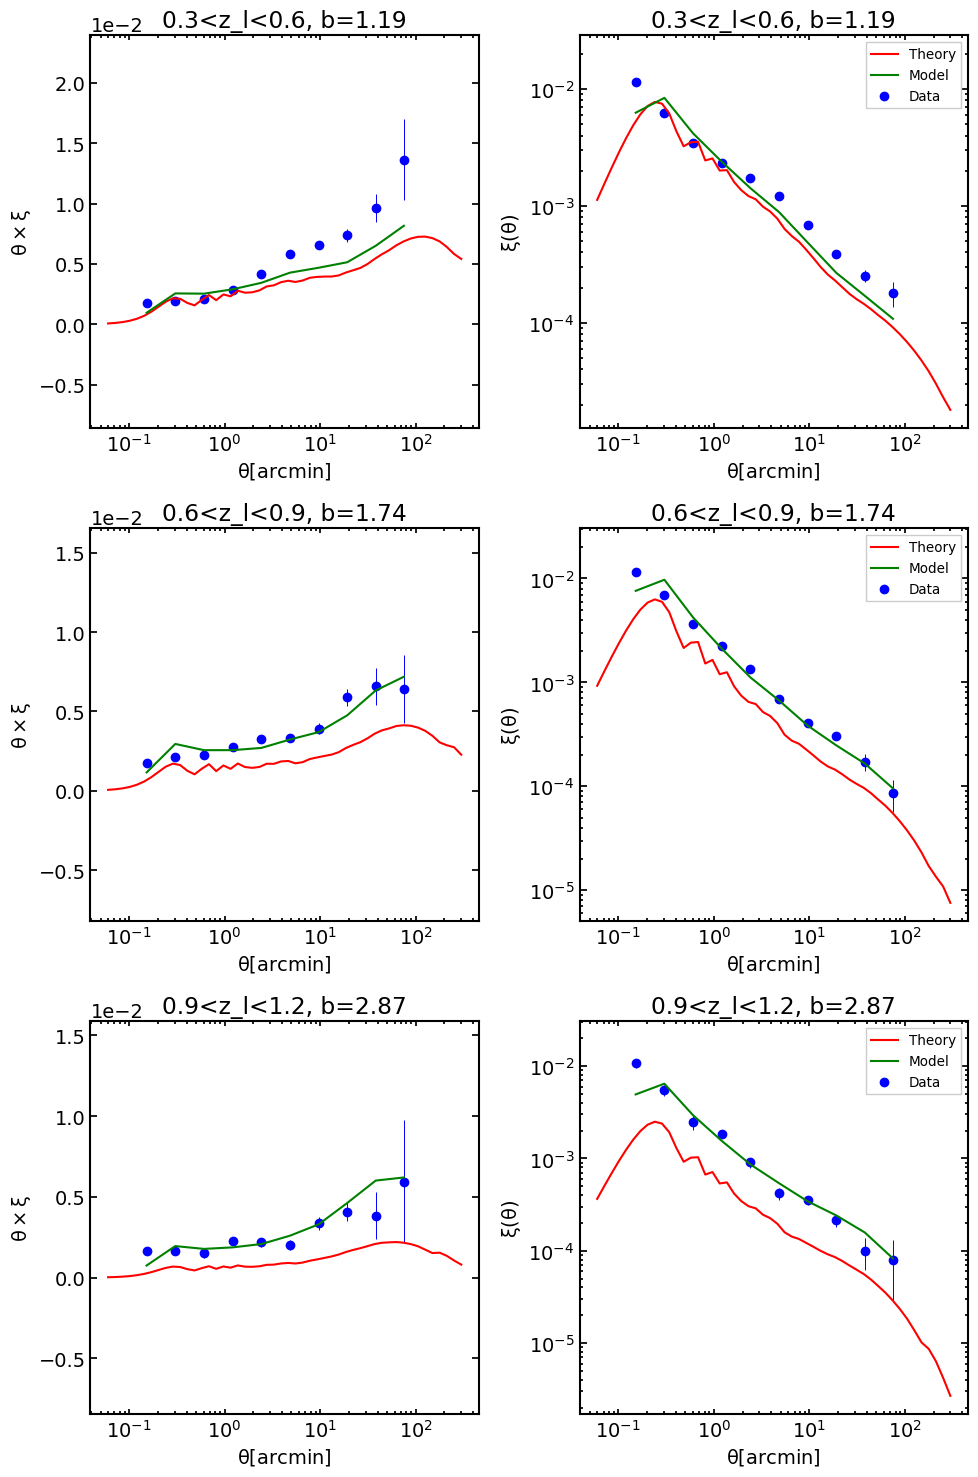

In [20]:
min_b_ng_comp(pz_ranges[1:-3], ng_min_b)

In [21]:
def min_b_nn_comp(pz_range, min_b):
    fig, ax = plt.subplots(len(pz_range), 2, figsize=(10, 20))
    for i in range(len(pz_range)):
        b = min_b[i]
        title = '{:.1f}<pz<{:.1f}, b={:.2f}'.format(pz_range[i], pz_range[i]+0.3, b)
        ax[i][0].set_title(title)
        ax[i][1].set_title(title)
        r_data, xi_data, xi_sig, cov = get_data('NN', i)
        r_theo, xi_theo = get_theo('NN', i)
        f = interpolate.interp1d(r_theo, xi_theo)
        xi_theo_interp = f(r_data)
        xi_model = (b**2)*xi_theo_interp
        
        plot_xi_mod('scatter', ax[i][0], r_data, xi_data, 'Data', 'blue', xi_sig)
        plot_xi_mod('plot', ax[i][0], r_theo, xi_theo, 'Theory', 'red')
        plot_xi_mod('plot', ax[i][0], r_data, xi_model, 'Model', 'green')
        
        plot_xi('scatter', ax[i][1], r_data, xi_data, 'Data', 'blue', xi_sig)
        plot_xi('plot', ax[i][1], r_theo, xi_theo, 'Theory', 'red')
        plot_xi('plot', ax[i][1], r_data, xi_model, 'Model', 'green')
        ax[i][1].legend()
    return

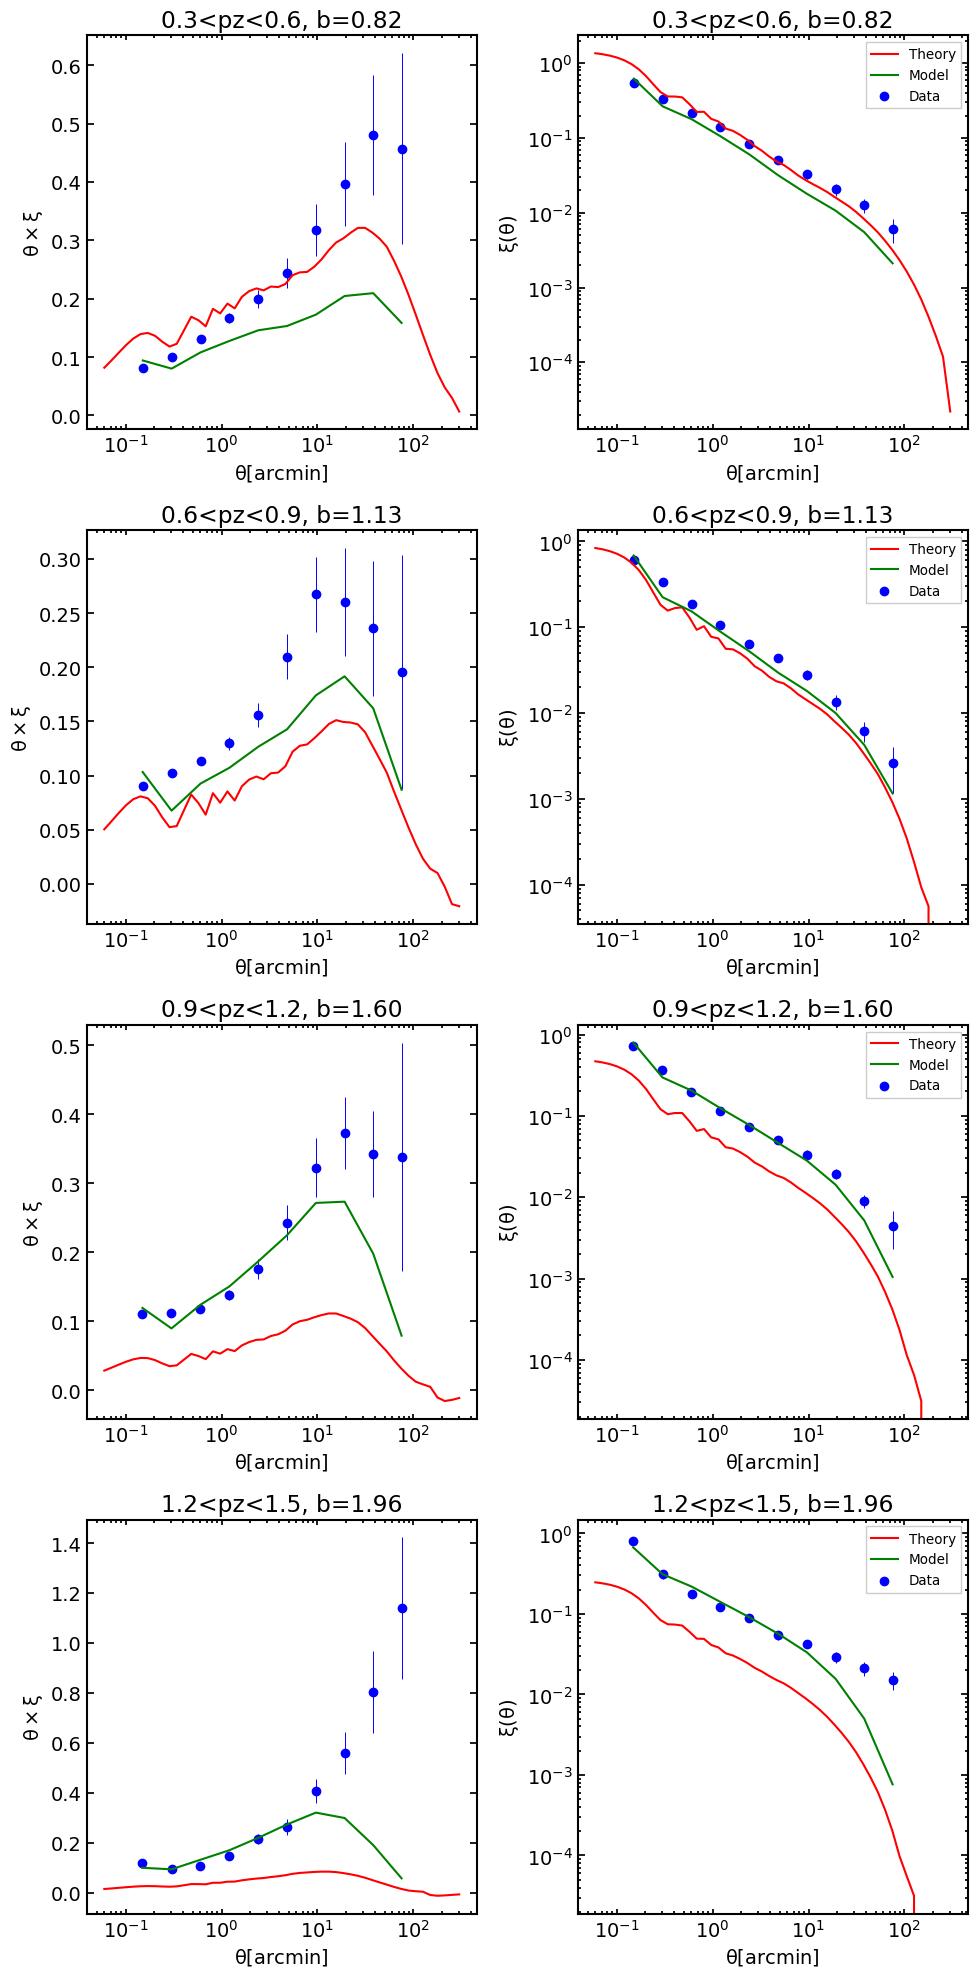

In [22]:
min_b_nn_comp(pz_ranges[1:-2], nn_min_b)

In [23]:
def ng_pop(pz_range):
    b = np.linspace(0, 4, 500)
    fig, ax = plt.subplots(len(pz_range), 1, figsize=(5, 14))
    min_b = np.ones(len(pz_range)*8).reshape(len(pz_range), 8)
    min_chi = np.ones(len(pz_range)*8).reshape(len(pz_range), 8)
    for i in range(len(pz_range)):
        r_data, xi_data, xi_sig, cov = get_data('NG', i)
        r_theo, xi_theo = get_theo('NG', i)
        f = interpolate.interp1d(r_theo, xi_theo)
        xi_theo_interp = f(r_data)
        for j in range(len(r_data)-2):
            xi_model_mat = b[:,None]@xi_theo_interp[:,None].T
            chi_sqs = np.ones(len(b))
            for k in range(len(b)):
                xi_model = xi_model_mat[k]
                chi_sq = get_chi_sq(xi_data[j:], xi_model[j:], cov[j:,j:])
                chi_sqs[k] = chi_sq
            min_chi[i][j] = np.min(chi_sqs)
            min_b[i][j] = b[chi_sqs == np.min(chi_sqs)]
            label = r'$\chi^2$={:.2f}, b={:.2f}'.format(min_chi[i][j], min_b[i][j])
            plot_chi_sq(ax[i], b, chi_sqs, label, colorwheel[j])
        title = r'{:.1f}<z_l<{:.1f}'.format(pz_range[i], pz_range[i]+0.3)
        ax[i].set_title(title)
        ax[i].legend()
    return min_b, min_chi

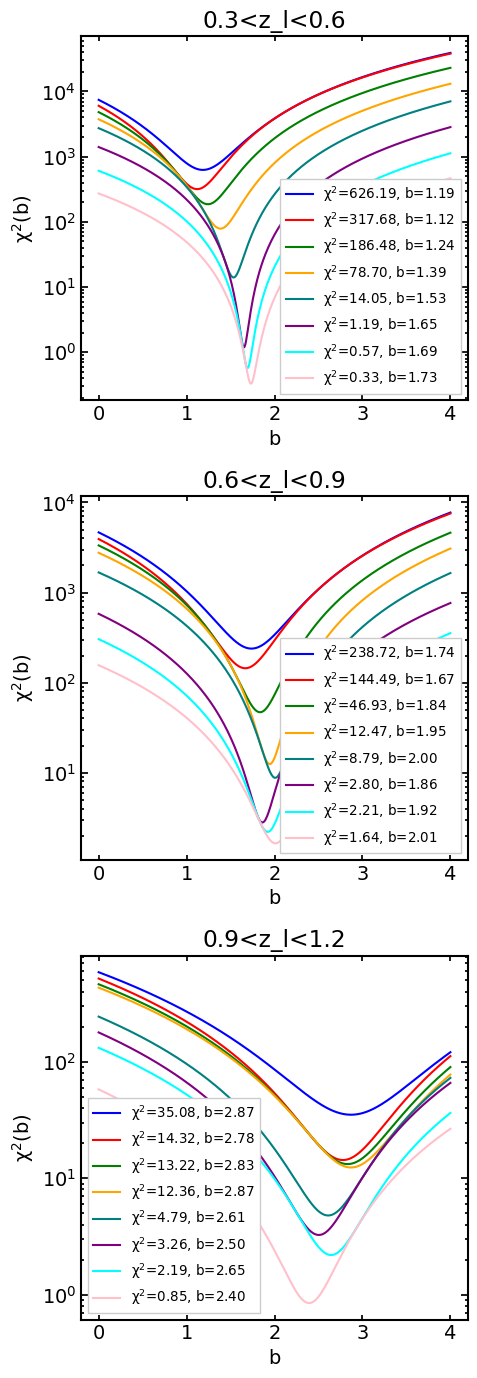

In [24]:
ng_min_b_new, ng_min_chi_new = ng_pop(pz_ranges[1:-3])

In [25]:
ng_min_b_new

array([[1.18637275, 1.12224449, 1.24248497, 1.38677355, 1.53106212,
        1.65130261, 1.69138277, 1.73146293],
       [1.73947896, 1.66733467, 1.83567134, 1.94789579, 2.00400802,
        1.85971944, 1.9238477 , 2.01202405],
       [2.86973948, 2.78156313, 2.82965932, 2.86973948, 2.61322645,
        2.501002  , 2.64529058, 2.39679359]])

In [26]:
def nn_pop(pz_range):
    b = np.linspace(0, 4, 500)
    fig, ax = plt.subplots(len(pz_range), 1, figsize=(5, 19))
    min_b = np.ones(len(pz_range)*8).reshape(len(pz_range), 8)
    min_chi = np.ones(len(pz_range)*8).reshape(len(pz_range), 8)
    for i in range(len(pz_range)):
        r_data, xi_data, xi_sig, cov = get_data('NN', i)
        r_theo, xi_theo = get_theo('NN', i)
        f = interpolate.interp1d(r_theo, xi_theo)
        xi_theo_interp = f(r_data)
        for j in range(len(r_data)-2):
            xi_model_mat = (b**2)[:,None]@xi_theo_interp[:,None].T
            chi_sqs = np.ones(len(b))
            for k in range(len(b)):
                xi_model = xi_model_mat[k]
                chi_sq = get_chi_sq(xi_data[j:], xi_model[j:], cov[j:,j:])
                chi_sqs[k] = chi_sq
            min_chi[i][j] = np.min(chi_sqs)
            min_b[i][j] = b[chi_sqs == np.min(chi_sqs)]
            label = r'$\chi^2$={:.2f}, b={:.2f}'.format(min_chi[i][j], min_b[i][j])
            plot_chi_sq(ax[i], b, chi_sqs, label, colorwheel[j])
        title = r'{:.1f}<pz<{:.1f}'.format(pz_range[i], pz_range[i]+0.3)
        ax[i].set_title(title)
        ax[i].legend()
    return min_b, min_chi

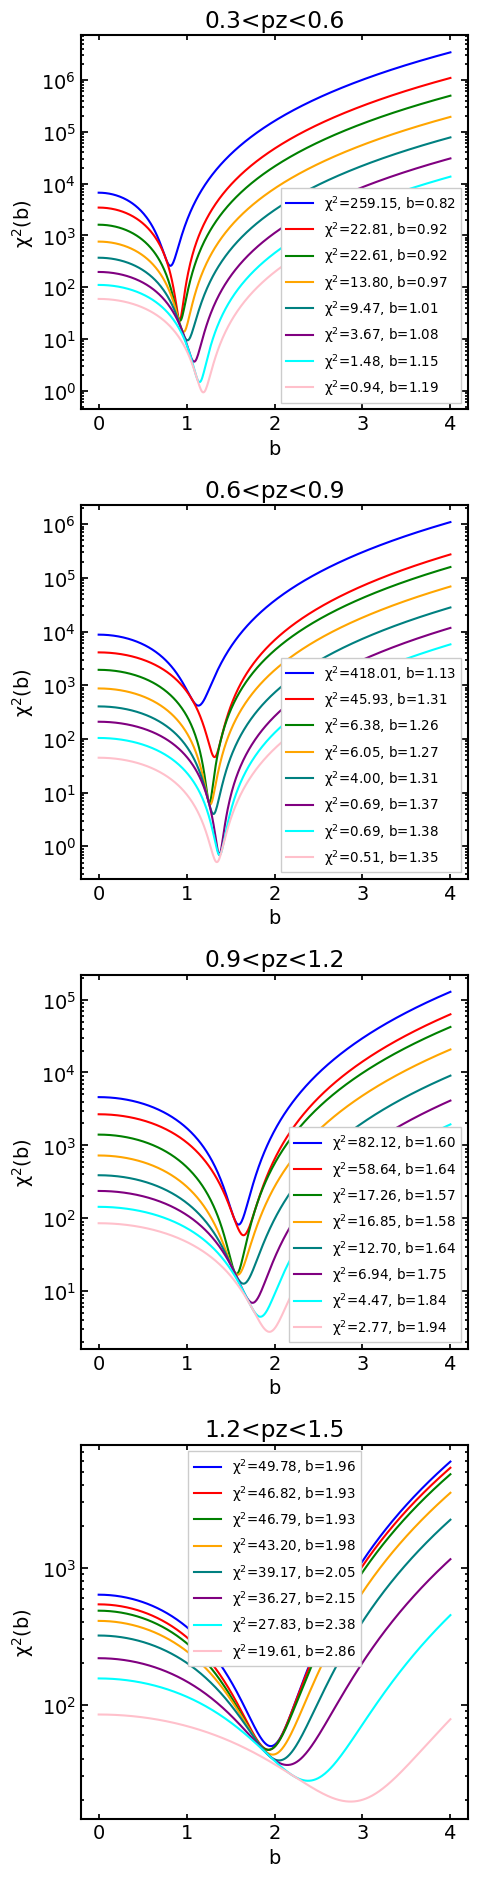

In [27]:
nn_min_b_new, nn_min_chi_new = nn_pop(pz_ranges[1:-2])

In [28]:
nn_min_b_new

array([[0.81763527, 0.92184369, 0.92184369, 0.96993988, 1.01002004,
        1.08216433, 1.14629259, 1.18637275],
       [1.13026052, 1.31462926, 1.25851703, 1.26653307, 1.30661323,
        1.37074148, 1.37875752, 1.34669339],
       [1.59519038, 1.64328657, 1.57114228, 1.57915832, 1.64328657,
        1.74749499, 1.83567134, 1.93987976],
       [1.95591182, 1.93186373, 1.93186373, 1.97995992, 2.05210421,
        2.14829659, 2.38076152, 2.86172345]])

In [29]:
ng_r_min_pos = [3, 2, 0]
nn_r_min_pos = [4, 5, 2, 0]

In [30]:
### Criteria: first combi that brings chi^2 below 100 ###
ng_min_b_new_all = np.asarray([ng_min_b_new[0,ng_r_min_pos[0]], 
                               ng_min_b_new[1,ng_r_min_pos[1]], 
                               ng_min_b_new[2,ng_r_min_pos[2]]])

nn_min_b_new_all = np.asarray([nn_min_b_new[0,nn_r_min_pos[0]], 
                               nn_min_b_new[1,nn_r_min_pos[1]], 
                               nn_min_b_new[2,nn_r_min_pos[2]], 
                               nn_min_b_new[3,nn_r_min_pos[3]]])

In [31]:
ng_min_b_new_all

array([1.38677355, 1.83567134, 2.86973948])

In [41]:
def min_b_ng_comp_new(pz_range, min_b):
    fig, ax = plt.subplots(len(pz_range), 2, figsize=(10, 15))
    r_min_pos = ng_r_min_pos
    for i in range(len(pz_range)):
        b = min_b[i]
        title = '{:.1f}<z_l<{:.1f}, b={:.2f}'.format(pz_range[i], pz_range[i]+0.3, b)
        ax[i][0].set_title(title)
        ax[i][1].set_title(title)
        r_data, xi_data, xi_sig, cov = get_data('NG', i)
        r_theo, xi_theo = get_theo('NG', i)
        f = interpolate.interp1d(r_theo, xi_theo)
        xi_theo_interp = f(r_data)
        xi_model = b*xi_theo_interp
        
        plot_xi_mod('scatter', ax[i][0], r_data, xi_data, 'Data', 'blue',  xi_sig)
        plot_xi_mod('plot', ax[i][0], r_theo, xi_theo, 'Theory', 'red')
        plot_xi_mod('plot', ax[i][0], r_data, xi_model, 'Model', 'green')
        ax[i][0].axvline(x=r_data[r_min_pos[i]])
        
        plot_xi('scatter', ax[i][1], r_data, xi_data, 'Data', 'blue', xi_sig)
        plot_xi('plot', ax[i][1], r_theo, xi_theo, 'Theory', 'red')
        plot_xi('plot', ax[i][1], r_data, xi_model, 'Model', 'green')
        ax[i][1].axvline(x=r_data[r_min_pos[i]])
        ax[i][1].legend()
    return

In [51]:
def min_b_nn_comp_new(pz_range, min_b):
    fig, ax = plt.subplots(len(pz_range), 2, figsize=(10, 20))
    r_min_pos = nn_r_min_pos
    for i in range(len(pz_range)):
        b = min_b[i]
        title = '{:.1f}<pz<{:.1f}, b={:.2f}'.format(pz_range[i], pz_range[i]+0.3, b)
        ax[i][0].set_title(title)
        ax[i][1].set_title(title)
        r_data, xi_data, xi_sig, cov = get_data('NN', i)
        r_theo, xi_theo = get_theo('NN', i)
        f = interpolate.interp1d(r_theo, xi_theo)
        xi_theo_interp = f(r_data)
        xi_model = (b**2)*xi_theo_interp
        
        plot_xi_mod('scatter', ax[i][0], r_data, xi_data, 'Data', 'blue', xi_sig)
        plot_xi_mod('plot', ax[i][0], r_theo, xi_theo, 'Theory', 'red')
        plot_xi_mod('plot', ax[i][0], r_data, xi_model, 'Model', 'green')
        ax[i][0].axvline(x=r_data[r_min_pos[i]])
        
        plot_xi('scatter', ax[i][1], r_data, xi_data, 'Data', 'blue', xi_sig)
        plot_xi('plot', ax[i][1], r_theo, xi_theo, 'Theory', 'red')
        plot_xi('plot', ax[i][1], r_data, xi_model, 'Model', 'green')
        ax[i][1].axvline(x=r_data[r_min_pos[i]])
        ax[i][1].legend()
    return

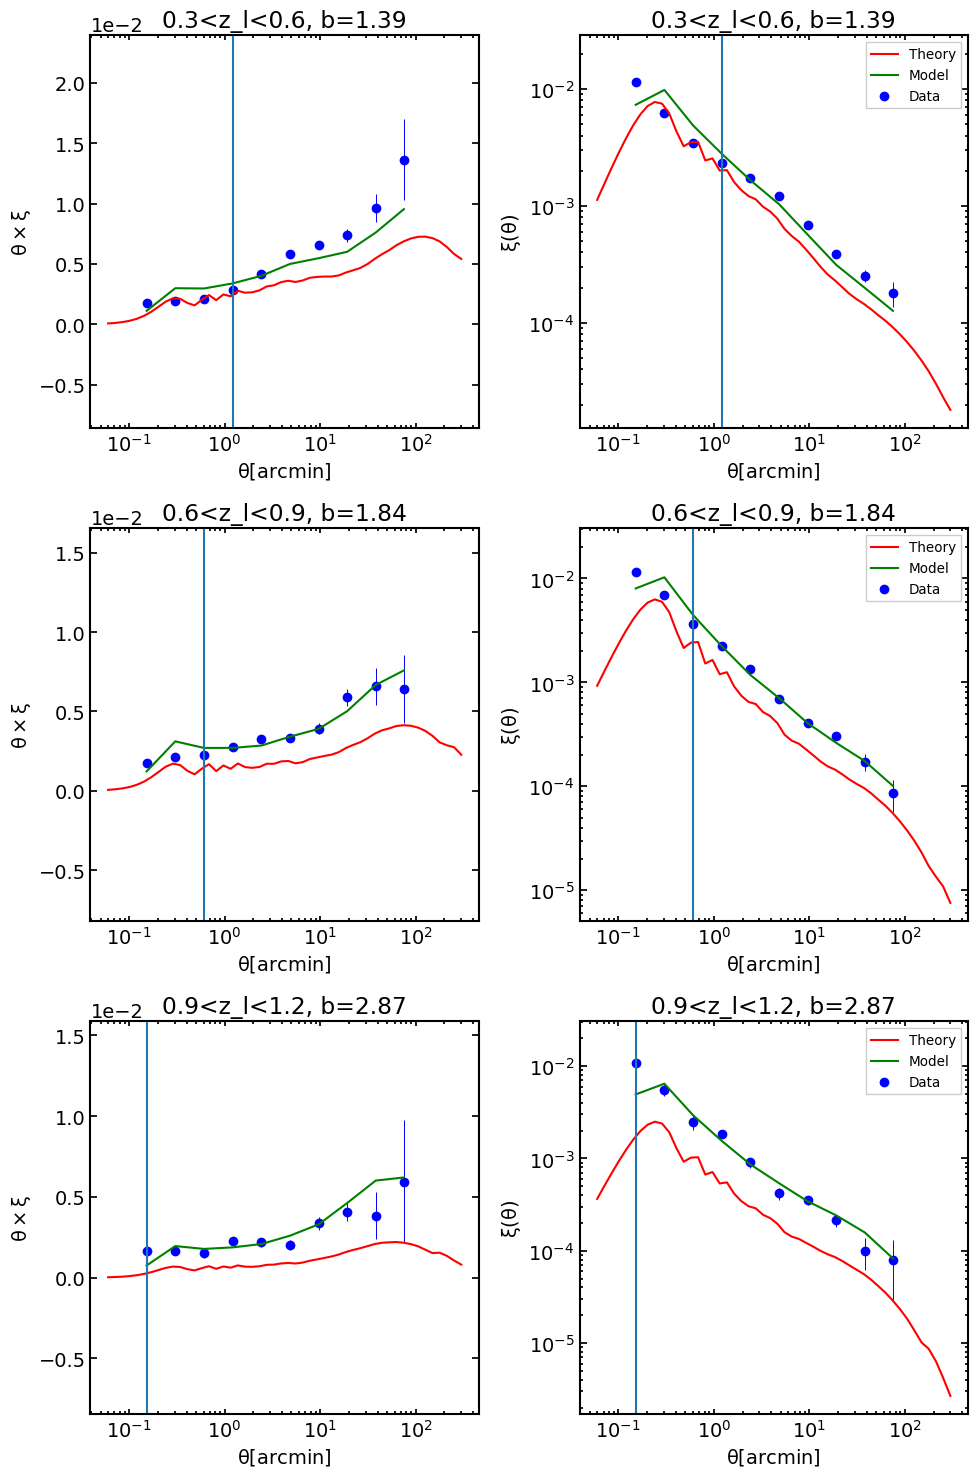

In [43]:
min_b_ng_comp_new(pz_ranges[1:-3], ng_min_b_new_all)

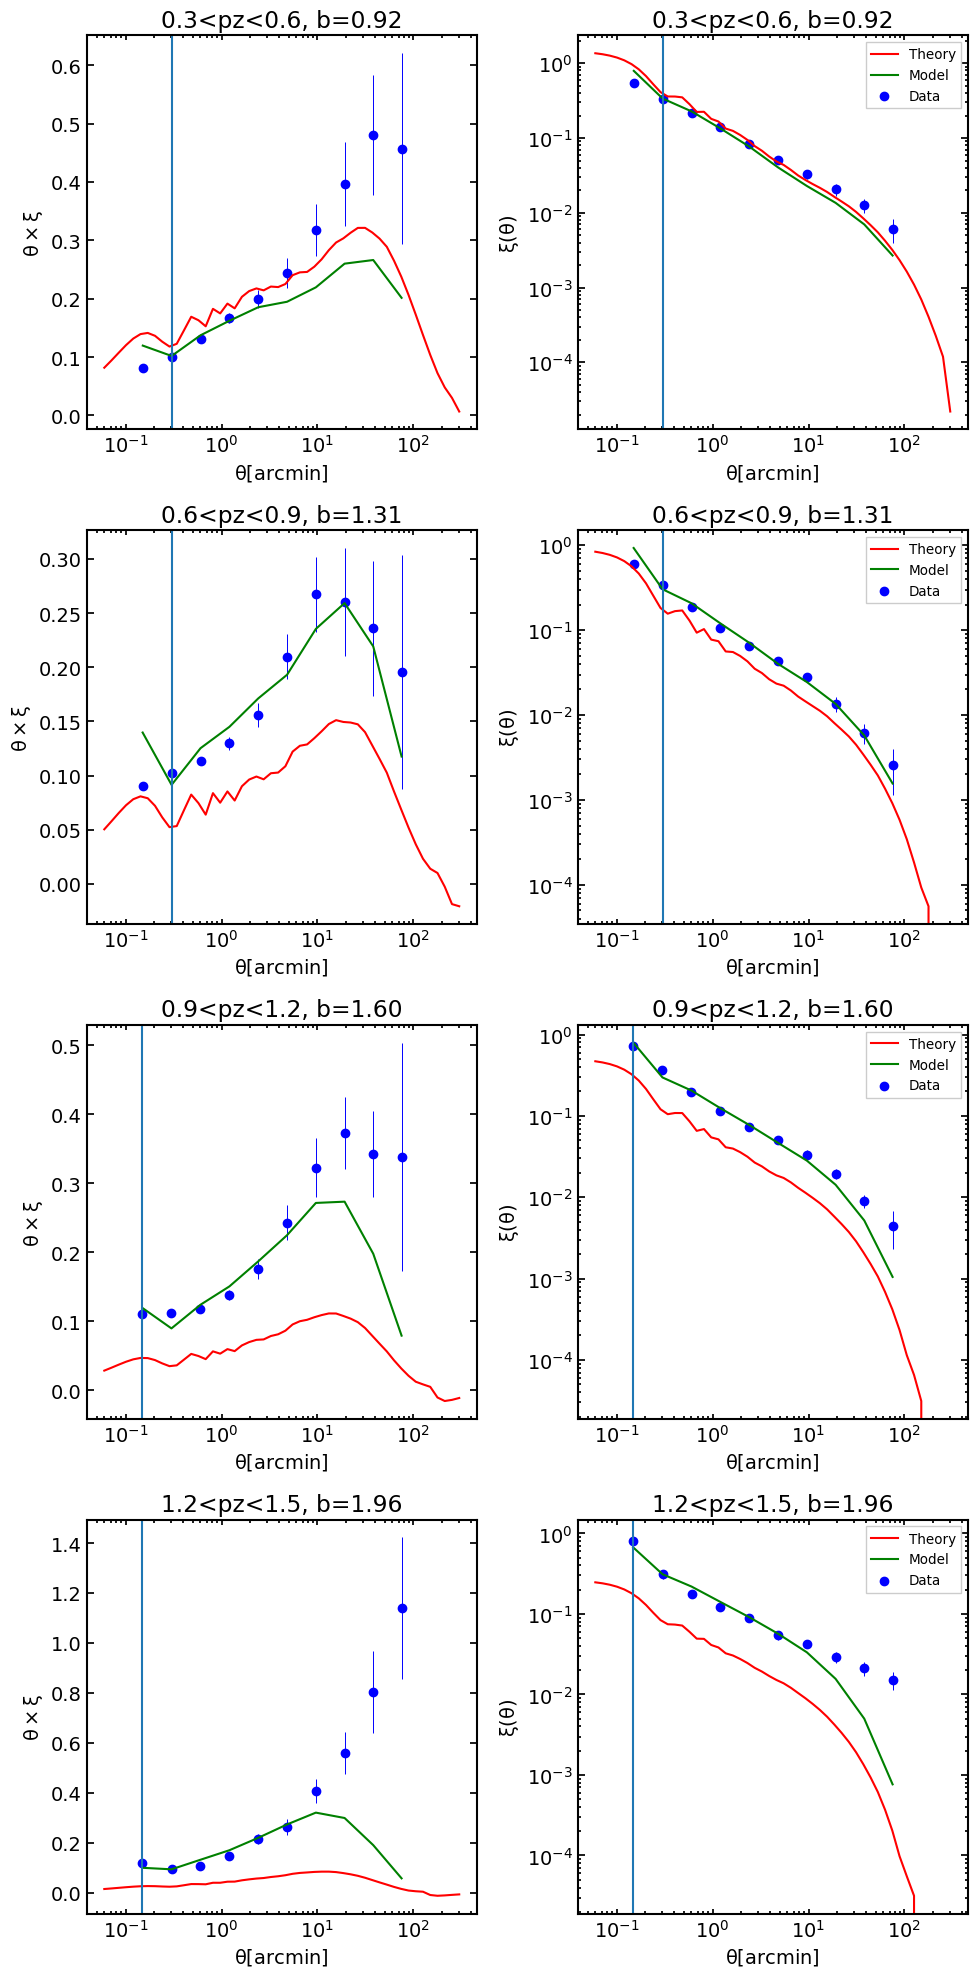

In [44]:
min_b_nn_comp_new(pz_ranges[1:-2], nn_min_b_new_all)

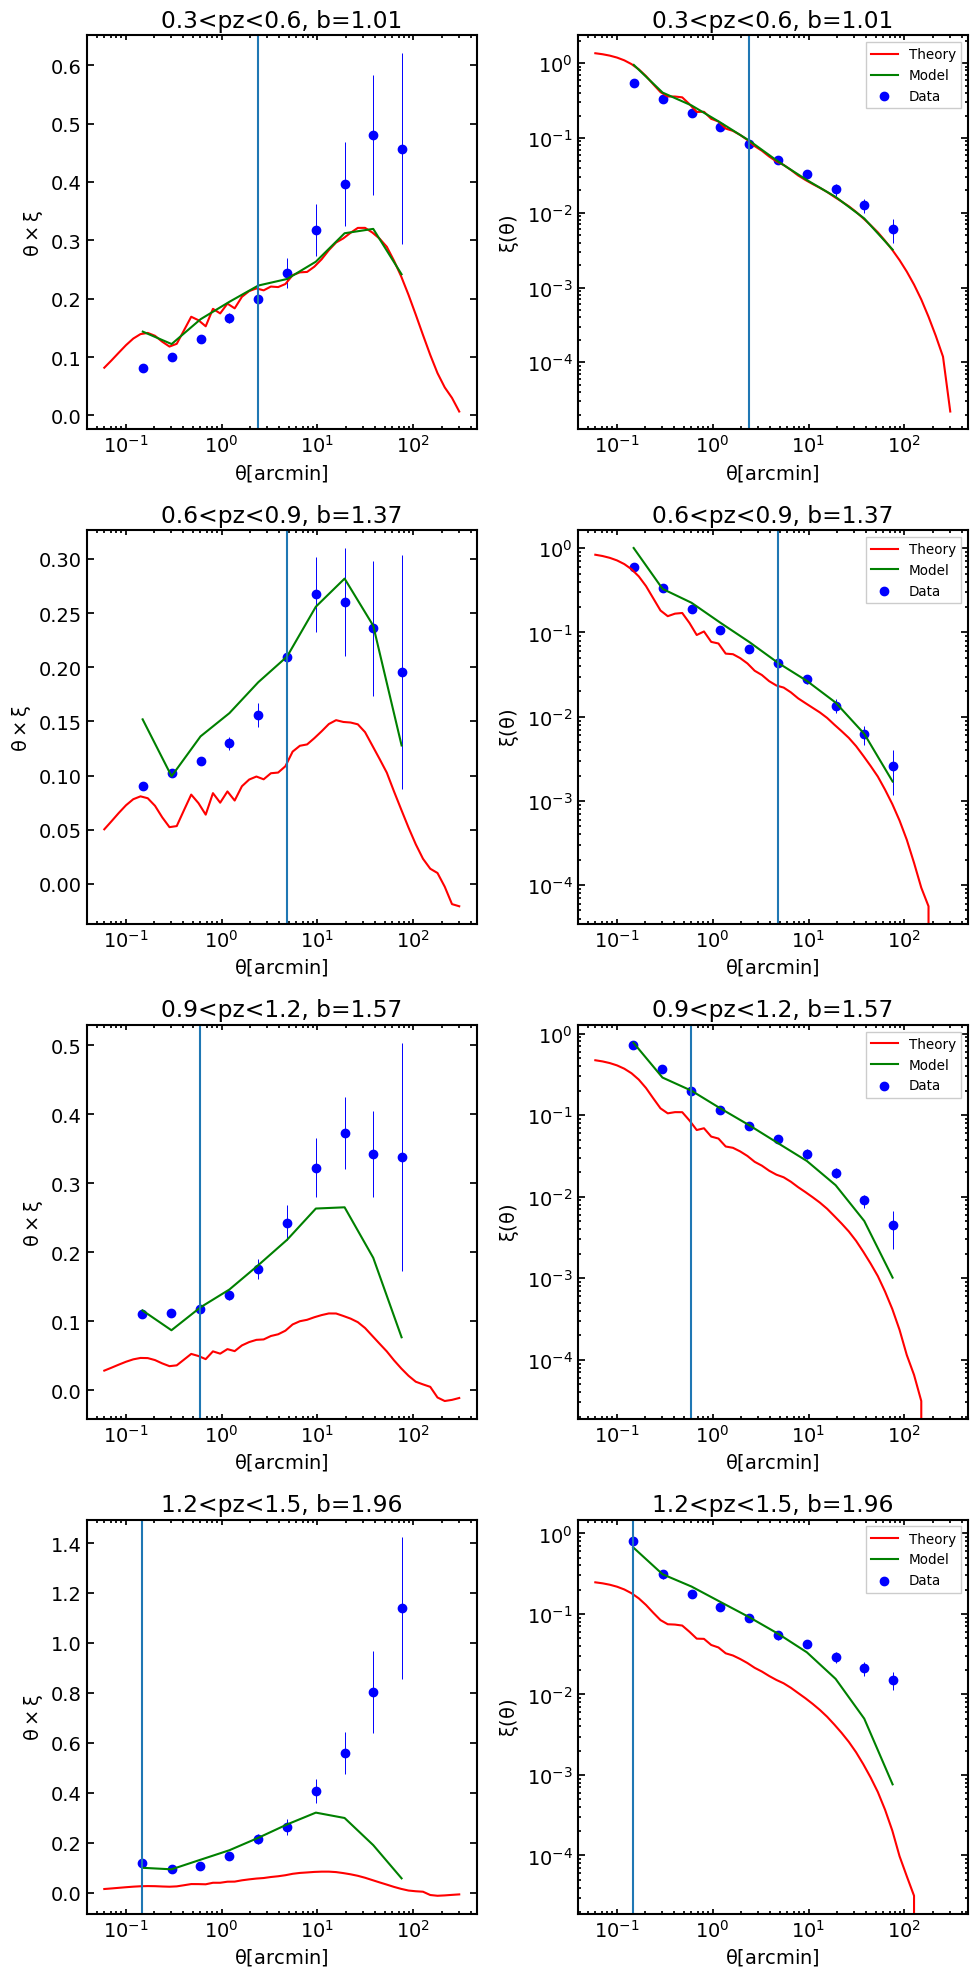

In [48]:
min_b_nn_comp_new(pz_ranges[1:-2], nn_min_b_new_all)

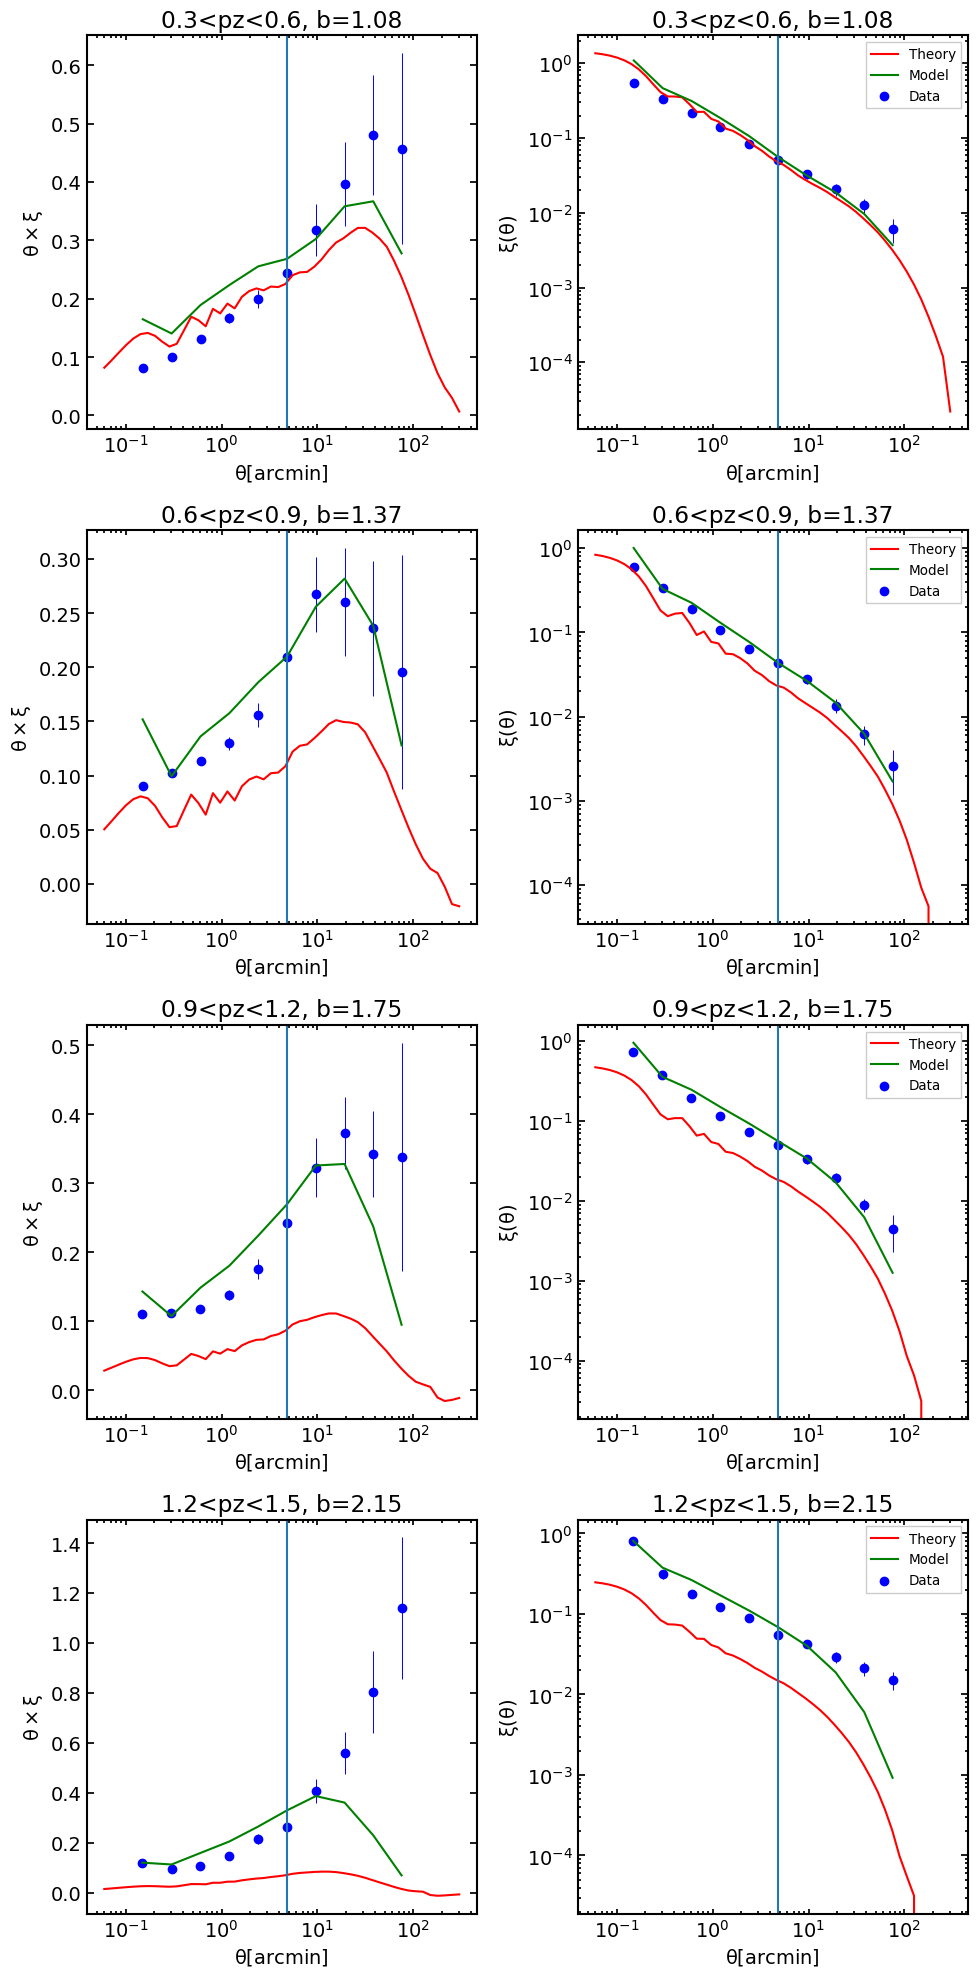

In [52]:
min_b_nn_comp_new(pz_ranges[1:-2], nn_min_b_new_all)